In [2]:
from __future__ import division, print_function
import sys 
sys.path.insert(0,'../rl_network'); import actorcritic as ac;  import stategen as sg
sys.path.insert(0,'../environments/'); import gridworld as eu
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline 
fig_savedir = '../data/figures/'
print_freq = 1/10
import importlib

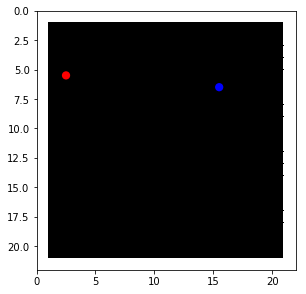

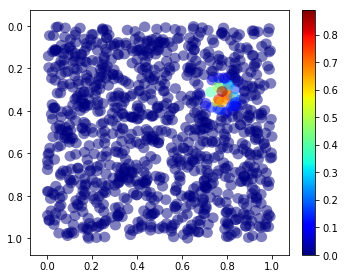

In [3]:
# environment parameters 
y_height = 20
x_width = 20
walls = True
#if not walls:
#    y_height = y_height+2
#    x_width = x_width+2
rho = 0
maze_type = 'none'
port_shift = 'none'

#make environment
maze = eu.gridworld([y_height, x_width], 
                    rho = rho, 
                    maze_type = maze_type, 
                    port_shift = port_shift, 
                    walls = walls)
#maze.rwd_loc = [(int(y_new/2),int(x_new/2))]
for i in maze.rwd_loc: 
    maze.orig_rwd_loc.append(i)



state_type = 'pcs'

if state_type == 'pcs':
    # place cell parameters
    num_pc = 1000
    fwhm = 0.05
    pcs = sg.PlaceCells(num_cells=num_pc, grid=maze, fwhm=fwhm)

    #show environment
    eu.make_env_plots(maze,env=True,pc_map=True,pcs=pcs, save=False)
else: 
    eu.make_env_plots(maze,env=True)

## test out gridworld wrapper. 
env = eu.gymworld(maze)



In [4]:
if state_type == 'conv':
    num_channels = 3 
    #if maze.bound:
    #    input_dims = (y_height+2,x_width+2,num_channels)
    #else: 
    #    input_dims = (y_height, x_width, num_channels)
    input_dims = (y_height, x_width, num_channels)
    hid_types = ['conv', 'pool', 'linear']
    conv_dims = ac.conv_output(input_dims)
    pool_dims = ac.conv_output(conv_dims)
    hid_dims = [conv_dims, pool_dims, 500]

elif state_type == 'pcs':
    input_dims = 1000
    hid_types = ['linear']
    hid_dims = [500]
    
action_dims = len(maze.actionlist)
batch_size = 1

NUM_EVENTS = 100
NUM_TRIALS = 5000

In [5]:
#importlib.reload(ac)
MF = ac.AC_Net(input_dims, action_dims, batch_size, hid_types, hid_dims)
discount_factor = 0.98

eta = 5e-4 #gradient descent learning rate
opt = ac.optim.Adam(MF.parameters(), lr = eta)

In [ ]:
total_loss = [[],[]]
total_reward = []
val_maps = []

blocktime = time.time()
for trial in range(NUM_TRIALS):
    reward_sum = 0
    if state_type == 'pcs':
        get_pcs = pcs.activity(env.reset())
        state = ac.Variable(ac.torch.FloatTensor(get_pcs))
    elif state_type == 'conv':
        env.reset()
        # because we need to include batch size of 1 
        frame = np.expand_dims(sg.get_frame(maze), axis=0)
        state = ac.Variable(ac.torch.FloatTensor(frame))
        
    MF.reinit_hid()
    for event in range(NUM_EVENTS):
        policy_, value_ = MF(state)
        choice, policy, value = ac.select_action(MF,policy_, value_)
        if event < NUM_EVENTS: 
            next_state, reward, done, info = env.step(choice)

        MF.rewards.append(reward)
        if state_type == 'pcs':
            state = ac.Variable(ac.torch.FloatTensor(pcs.activity(next_state)))       # update state
        elif state_type == 'conv':
            # because we need to include batch size of 1 
            frame = np.expand_dims(sg.get_frame(maze), axis = 0)
            state = ac.Variable(ac.torch.FloatTensor(frame))
        reward_sum += reward

    p_loss, v_loss = ac.finish_trial(MF, discount_factor,opt)
    
    total_loss[0].append(p_loss.data[0])
    total_loss[1].append(v_loss.data[0])
    total_reward.append(reward_sum)
    if state_type == 'pcs':
        value_map = ac.generate_values(maze,MF,pcs=pcs)
    else:
        value_map = ac.generate_values(maze,MF)
    val_maps.append(value_map.copy())
    
    if trial%(print_freq*NUM_TRIALS)==0 or trial == NUM_TRIALS-1: 
        print("[{0}]  Trial {1} total reward = {2} (Avg {3:.3f})".format(time.strftime("%H:%M:%S", time.localtime()), trial, reward_sum, float(reward_sum)/float(NUM_EVENTS)), "Block took {0:.3f}".format(time.time()-blocktime))
        blocktime = time.time() 

[12:13:06]  Trial 0 total reward = 0 (Avg 0.000) Block took 0.406
[12:15:56]  Trial 500 total reward = 59 (Avg 0.590) Block took 170.397
[12:18:49]  Trial 1000 total reward = 87 (Avg 0.870) Block took 173.397
[12:21:41]  Trial 1500 total reward = 84 (Avg 0.840) Block took 171.236
[12:24:37]  Trial 2000 total reward = 80 (Avg 0.800) Block took 176.000


In [ ]:
plt.plot(total_loss[0], label='p')
plt.plot(total_loss[1], label='v')
plt.legend(loc=0)
plt.show()

plt.plot(total_reward, label='r', color='r')

In [ ]:
reload(eu)
eu.print_value_maps(maze,
                    val_maps,
                    maps='all', #list(np.arange(841, 894)), 
                    val_range=(-1,50),
                    save_dir=fig_savedir,
                    title='Value Map') ### see individual map with kwarg maps=X

In [ ]:
#store_data = {}
store_data['bound'] = [total_loss, total_reward, val_maps]